<a href="https://colab.research.google.com/github/eldhosejoseph/thesis/blob/main/BCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Links:

Thesis
======
Lit Rev. doc:

https://essexuniversity-my.sharepoint.com/:w:/g/personal/ej23373_essex_ac_uk/ETT7lRYeuXtPtblJcIEk8RoBCZQh4n3iwu6D9PdIGTfqIg?e=85Tcdg

Lit Rev. excel

https://essexuniversity-my.sharepoint.com/:x:/g/personal/ej23373_essex_ac_uk/EcJZ_XBNmeJDnpupWDcv3d8BSXQg_tGeqG7sapKg2hQPsQ?e=VfMMKz

Link doc

https://essexuniversity-my.sharepoint.com/:w:/g/personal/ej23373_essex_ac_uk/Ec8YxFG32FJJsTI_q4_fxZkBXSzl8kM7KdRIbC3ODjDmHg?e=UGIrrR


Thesis meeting link

https://essexuniversity-my.sharepoint.com/:w:/r/personal/ej23373_essex_ac_uk/_layouts/15/Doc.aspx?sourcedoc=%7B643F9DC8-2E85-4125-B005-BACF65A8209B%7D&file=Thesis-Term3-Meeting%20Notes.docx&action=default&mobileredirect=true&DefaultItemOpen=1&login_hint=ej23373%40essex.ac.uk&ct=1718975916814&wdOrigin=OFFICECOM-WEB.MAIN.REC&cid=4861056d-f36b-4977-b756-b9b5e94250e8&wdPreviousSessionSrc=HarmonyWeb&wdPreviousSession=4500332f-d0be-48f2-b358-b1a4a32a7b84

**Dataset**

An EEG Dataset of Neural Signatures in a Competitive Two-Player Game Encouraging Deceptive Behavior

Paper: https://www.nature.com/articles/s41597-024-03234-y :An EEG Dataset of Neural Signatures in a Competitive Two-Player Game Encouraging Deceptive Behavior

Pre-print: https://assets-eu.researchsquare.com/files/rs-2521275/v1_covered.pdf?c=1676412896

Supplementary Files: https://assets-eu.researchsquare.com/files/rs-2521275/v1/ee537dc92ed9e0bcb9e4ca87.pdf

Dataset: https://figshare.com/articles/dataset/An_EEG_Dataset_of_Neural_Signatures_in_a_Competitive_Two-Player_Game_Encouraging_Deceptive_Behavior/24760827/3

git: https://github.com/yiyuchen-lab/DeceptionGame


# Libraries and Packages

In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 43.4 MB/s eta 0:00:00


In [2]:
import mne
import os
import re
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Import [Competitive Two Player Game- Deception Task]

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def eegfiles(n):

    def get_filtered_files(folder_path):
        # Regular expression pattern to match the required file format
        pattern = re.compile(r'Player_(sub\d+)_Observer_(sub\d+)\.mat')

        # Dictionary to store the filtered files
        filtered_files = {}

        # Check if the folder exists
        if not os.path.isdir(folder_path):
            print(f"The folder '{folder_path}' does not exist.")
            return filtered_files

        # Iterate over files in the specified folder
        for filename in os.listdir(folder_path):
            if filename.endswith('.mat'):
                match = pattern.match(filename)
                if match:
                    player_id = match.group(1)
                    p_key = f"p{int(player_id[3:])}"  # Convert subXX to pX
                    if p_key not in filtered_files:
                        filtered_files[p_key] = []
                    # Store the file path in the dictionary
                    filtered_files[p_key].append(os.path.join(folder_path, filename))

        return filtered_files

    def get_key_list(filtered_files):
        # Return the list of keys
        return list(filtered_files.keys())

    def get_specific_files(filtered_files, key):
        # Return the list of files for the specified key
        return filtered_files.get(key, [])

    # Specify the folder containing the .txt files
    folder_path = '//content/drive/MyDrive/thesisdata/eegdataset/24760827eeg/Preprocessed/Preprocessed/DecisionMaking'

    # Get the filtered files
    filtered_files = get_filtered_files(folder_path)

    # Get the list of keys
    keys = get_key_list(filtered_files)

    # Print the list of keys
    #print("List of keys:", keys)

    # Get specific files for a key, e.g., p1
    keys = [f'p{i}' for i in range(1, 25) if i != 2]
    key_to_retrieve = keys[n]
    specific_files = get_specific_files(filtered_files, key_to_retrieve)

    # Print the files for the specified key
    #print(f"\nFiles for {key_to_retrieve}:")
    for file in specific_files:
        #print(f"  {file}")
        return  file

In [6]:
# Define options
opt = {
    'preprocessedData_path': '/content/drive/MyDrive/thesisdata/eegdataset/24760827eeg/Preprocessed/Preprocessed/DecisionMaking',
    'epoch_type': ['DecisionMaking'],
    'session_role': ['player','observer'],
    'eegmarker_label': {
        'showCard': ['sponL', 'sponT', 'instL', 'instT']
    }
}

# Load data
data_path = os.path.join(opt['preprocessedData_path'], opt['epoch_type'][0])

files=[]
for n in range(23):
  files.append(eegfiles(n))

filenames = [f for f in files if f.endswith('.mat')]
epos = []
for file in filenames:
    mat = sio.loadmat(os.path.join(data_path, file))
    epos.append(mat[opt['session_role'][0]])

# ERP ANALYSIS

In [7]:
player=0
mode=1  #0-100, 1-eeg, 2-channel name, 3-sample, 4-cards, 5-timestamp 6-player name set
cardsample=1  #0-sponL, 1-sponT, 2-instL, 3-instT
channelnum=1
epos[player][0][0][mode][349][0][0]

-0.4117603003978729

In [8]:
#data
player=0
channelnum=1
cardsample=1

#eeg
mode=1
channel_num=0
trial=0
eeg=epos[player][0][0][mode][0][channel_num][trial]

#channel names
mode=2
ch_names=epos[player][0][0][mode][0]

#sample
mode=3
card_category=0    #0-sponL, 1-sponT, 2-instL, 3-instT
trial=0 #44 trials * 11 =484 trials
samples=epos[player][0][0][mode]  #4 sample category sublist
samples_cat=samples[card_category]
samples_trial=samples_cat[trial]

#cards
mode=4
cards=epos[player][0][0][mode][0]

#timestamp
mode=5
timestamps=epos[player][0][0][mode][0]

#player name set
mode=6
player_name=epos[player][0][0][mode][0]

In [9]:
ch_names

array([array(['F7'], dtype='<U2'), array(['F3'], dtype='<U2'),
       array(['Fz'], dtype='<U2'), array(['F4'], dtype='<U2'),
       array(['F8'], dtype='<U2'), array(['FC5'], dtype='<U3'),
       array(['FC1'], dtype='<U3'), array(['FC2'], dtype='<U3'),
       array(['FC6'], dtype='<U3'), array(['T7'], dtype='<U2'),
       array(['C3'], dtype='<U2'), array(['Cz'], dtype='<U2'),
       array(['C4'], dtype='<U2'), array(['T8'], dtype='<U2'),
       array(['CP5'], dtype='<U3'), array(['CP1'], dtype='<U3'),
       array(['CP2'], dtype='<U3'), array(['CP6'], dtype='<U3'),
       array(['P7'], dtype='<U2'), array(['P3'], dtype='<U2'),
       array(['Pz'], dtype='<U2'), array(['P4'], dtype='<U2'),
       array(['P8'], dtype='<U2'), array(['PO3'], dtype='<U3'),
       array(['PO4'], dtype='<U3'), array(['O1'], dtype='<U2'),
       array(['O2'], dtype='<U2'), array(['F9'], dtype='<U2'),
       array(['F10'], dtype='<U3'), array(['Fp2'], dtype='<U3')],
      dtype=object)

In [10]:
def player_df(player):
    # Data extraction based on the provided indices and modes
    # Extract EEG data for each trial
    eeg_data = epos[player][0][0][1]

    # Extract channel names
    ch_names = epos[player][0][0][2][0]

    # Extract samples (trial categories)
    samples = epos[player][0][0][3]

    # Extract cards (round and trial data)
    cards = epos[player][0][0][4][0]

    # Extract timestamps
    timestamps = epos[player][0][0][5][0]

    # Create an empty list to store the rows of the dataframe
    data_rows = []

    # Number of rounds and trials per round
    num_rounds = 11
    trials_per_round = 44

    # Map sample indices to categories
    sample_to_category = {0: 'sponL', 1: 'sponT', 2: 'instT', 3: 'instL'}  #changed here

    # Loop through the rounds and trials to create rows for the dataframe
    for r in range(num_rounds):
        for t in range(trials_per_round):
            # Calculate the overall trial index
            trial_index = r * trials_per_round + t

            # Check if trial_index is within bounds
            if trial_index >= len(samples[0]):
                continue

            # Determine the category for the current trial
            category = None
            for cat_index, trials in enumerate(samples):
                if trials[trial_index] == 1:
                    category = sample_to_category[cat_index]
                    break

            # Create a row for the dataframe
            row = [r+1, t+1, category]

            # Append EEG data for each channel to the row as a list of values
            for ch in range(30):
                channel_data = [eeg_data[i][ch][trial_index] for i in range(350)]
                row.append(channel_data)

            # Append the row to the list of data rows
            data_rows.append(row)

    # Create column names
    column_names = ['round', 'trial', 'category'] + [f'channel_{i}' for i in range(1,31)]

    # Create the dataframe
    df = pd.DataFrame(data_rows, columns=column_names)

    return df

def grand_average(channel_num):
  if channel_num in range(1,31):
      all_players_data = []

      # Iterate through all players and gather their data
      for p in range(len(epos)):
          df = player_df(p)
          all_players_data.append(df)

      # Combine all players' data into one DataFrame
      combined_df = pd.concat(all_players_data, ignore_index=True)

      # Initialize a dictionary to hold the grand average for each category
      grand_averages = {'sponL': [], 'sponT': [], 'instL': [], 'instT': []}

      # Calculate the grand average for each category
      for category in grand_averages.keys():
          category_data = combined_df[combined_df['category'] == category]

          # Collect all EEG lists for the specified channel across all trials for the current category
          all_eeg_lists = np.array(category_data[f'channel_{channel_num}'].tolist())

          # Calculate the grand average by taking the mean across the first dimension (trials)
          grand_averages[category] = np.mean(all_eeg_lists, axis=0)
  return grand_averages

def plot_erp(channel_num):
    if channel_num in range(1,31):
      grand_averages=grand_average(channel_num)

      # Extract timestamps
      timestamps = epos[0][0][0][5][0]  # Assuming timestamps are the same for all players

      # Define the range for x-axis in milliseconds
      x_range = (-100, 700)
      timestamps_ms = np.array(timestamps)  # Convert timestamps to milliseconds

      # Filter the timestamps and grand averages to include only the desired range
      valid_indices = np.where((timestamps_ms >= x_range[0]) & (timestamps_ms <= x_range[1]))[0]

      # Plot the grand averages
      plt.figure(figsize=(10, 6))
      color_cat={'sponL': 'blue', 'sponT': 'cyan' , 'instT': 'orange' , 'instL': 'red' }
      for category, data in grand_averages.items():
          #plt.plot(data, label=category)
          plt.plot(timestamps_ms[valid_indices], np.array(data)[valid_indices], label=category, color=color_cat[category])

      plt.title(f'Grand Average ERP for Channel {channel_num}[{ch_names[channel_num-1][0]}]')
      plt.xlabel('Time Points')
      plt.ylabel('EEG Amplitude')
      plt.legend()
      plt.grid(True)
      plt.show()

    else:
      print('Channel Num range: [1,30]')

In [ ]:
player_df(0)

In [15]:
#grand_average(0)

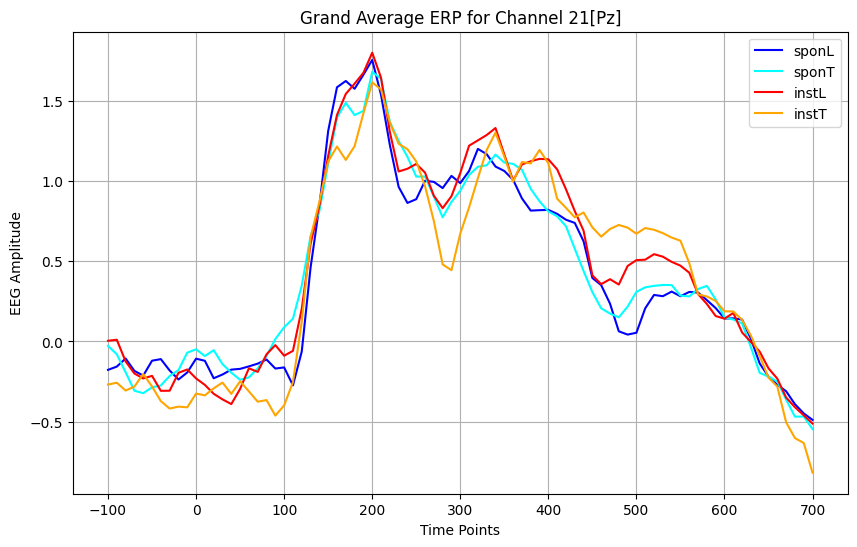

In [17]:
plot_erp(21)

In [18]:
def plot_all_channels():
    # Extract timestamps
    timestamps = epos[0][0][0][5][0]  # Assuming timestamps are the same for all players

    # Define the range for x-axis in milliseconds
    x_range = (-100, 700)
    timestamps_ms = np.array(timestamps)  # Convert timestamps to milliseconds

    # Filter the timestamps to include only the desired range
    valid_indices = np.where((timestamps_ms >= x_range[0]) & (timestamps_ms <= x_range[1]))[0]

    # Create subplots
    fig, axs = plt.subplots(6, 5, figsize=(20, 20))
    fig.suptitle('Grand Average ERP for All Channels')

    for channel_num in range(1, 31):
        grand_averages = grand_average(channel_num)

        row = (channel_num - 1) // 5
        col = (channel_num - 1) % 5
        ax = axs[row, col]

        color_cat={'sponL': 'blue', 'sponT': 'cyan' , 'instT': 'orange' , 'instL': 'red' }
        for category, data in grand_averages.items():
            ax.plot(timestamps_ms[valid_indices], np.array(data)[valid_indices], label=category, color=color_cat[category])

        ax.set_title(f'Channel {channel_num} [{ch_names[channel_num-1][0]}]')
        ax.set_xlabel('Time Points (ms)')
        ax.set_ylabel('EEG Amplitude')
        ax.legend()
        ax.grid(True)
        if channel_num == 1:
            ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#plot_all_channels()


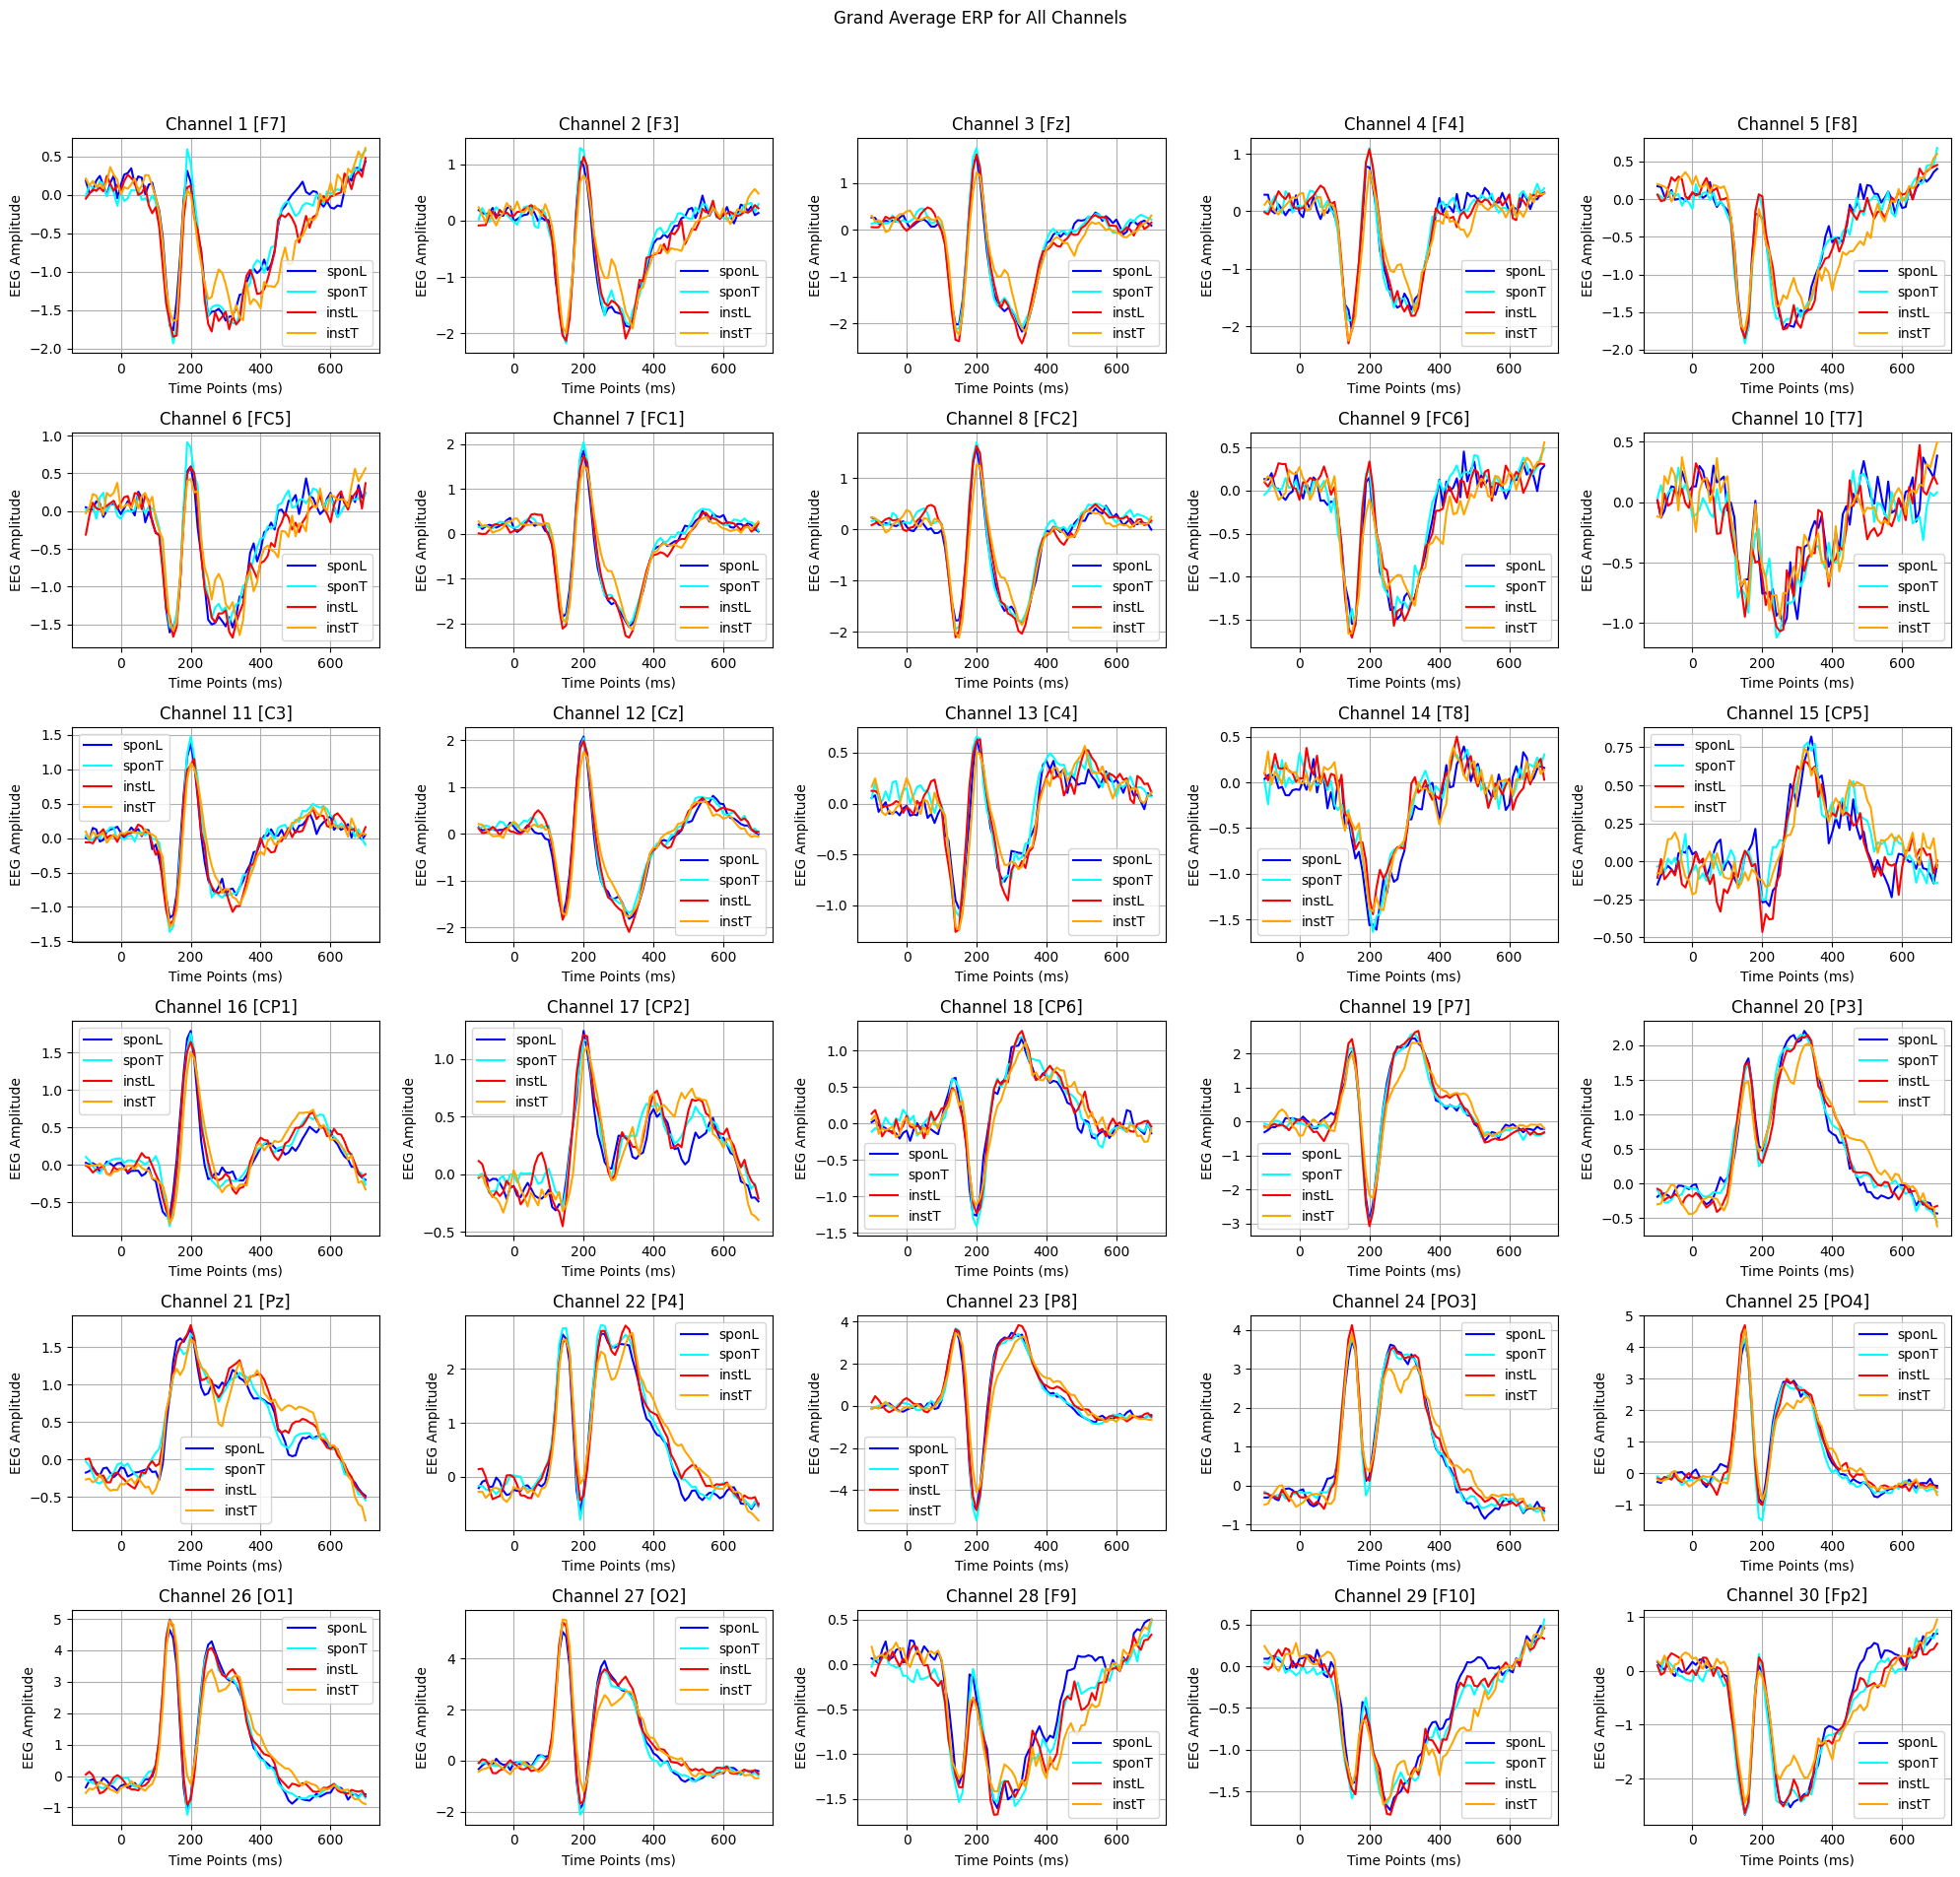